In [ ]:
!pip install bertopic
!pip install sentence-transformers
!pip install wordcloud
!pip install transformers
!pip install datasets
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 13.1 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import gc  # Garbage collector for memory management
# Import necessary libraries for PEFT
from peft import LoraConfig, TaskType, get_peft_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import transformers
print("🤗 Transformers version:", transformers.__version__)

🤗 Transformers version: 4.51.3


In [ ]:
# Check GPU availability and configuration
print("Checking GPU availability...")
if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # Set default tensor type to cuda for better performance
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda")
else:
    print("❌ GPU not available, using CPU instead")
    device = torch.device("cpu")

# Function for memory management
def clear_gpu_memory():
    """Clear GPU memory cache to prevent out-of-memory errors"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("GPU memory cleared")

Checking GPU availability...
✅ GPU is available: Tesla T4
Total GPU Memory: 15.83 GB


In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Set up colors and style for visualizations
plt.style.use('fivethirtyeight')
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

print("Setup complete! Let's start analyzing product reviews.")

Setup complete! Let's start analyzing product reviews.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# https://nijianmo.github.io/amazon/index.html
file_path = "Digital_Music_5.json"

In [ ]:
# Create a function to load the data
def load_amazon_data(file_path):
    """
    Load Amazon review data from a JSON file and return a sample.

    """
    try:
        df = pd.read_json(file_path, lines=True)


        return df

    except Exception as e:
        print(f"Error loading data: {e}")

In [ ]:
# # Determine appropriate sample size based on available GPU memory
# if torch.cuda.is_available():
#     # Calculate memory available and adjust sample size accordingly
#     # This is a very rough heuristic - adjust as needed
#     gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
#     if gpu_memory_gb < 8:
#         sample_size = 10000  # Small GPU
#     elif gpu_memory_gb < 12:
#         sample_size = 25000  # Medium GPU
#     else:
#         sample_size = 50000  # Large GPU
#     print(f"Auto-configured sample size based on GPU memory: {sample_size}")
# else:
#     sample_size = 10000  # Smaller sample size for CPU
#     print(f"Using sample size of {sample_size} for CPU processing")

# Load the data
df = load_amazon_data(file_path)

print("\nInitial data loaded.")
print(f"Original number of reviews: {len(df)}")

# Check for missing values in critical columns
print("\nChecking for missing values in 'overall' and 'reviewText':")
print(df[['overall', 'reviewText']].isnull().sum())

# Remove rows where 'overall' or 'reviewText' is missing
# Also remove rows where reviewText is just an empty string after stripping whitespace
initial_rows = len(df)
df.dropna(subset=['overall', 'reviewText'], inplace=True)
df = df[df['reviewText'].str.strip() != ''] # Remove reviews that become empty after stripping

# Report how many rows were dropped
rows_dropped = initial_rows - len(df)
if rows_dropped > 0:
    print(f"\nRemoved {rows_dropped} rows with missing 'overall' rating or missing/empty 'reviewText'.")
print(f"Number of reviews after cleaning: {len(df)}")

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(df.head())

# Basic statistics
print("\nBasic statistics:")
print(f"Number of reviews: {len(df)}")
print(f"Average rating: {df['overall'].mean():.2f}")
print(f"Rating distribution:")
display(df['overall'].value_counts().sort_index())


Initial data loaded.
Original number of reviews: 169781

Checking for missing values in 'overall' and 'reviewText':
overall         0
reviewText    158
dtype: int64

Removed 158 rows with missing 'overall' rating or missing/empty 'reviewText'.
Number of reviews after cleaning: 169623

First few rows of the dataset:


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN



Basic statistics:
Number of reviews: 169623
Average rating: 4.70
Rating distribution:


,count
overall,
1,2192
2,1812
3,6792
4,23142
5,135685


In [ ]:
# Convert ratings to sentiment classes
def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['overall'].apply(rating_to_sentiment)
df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

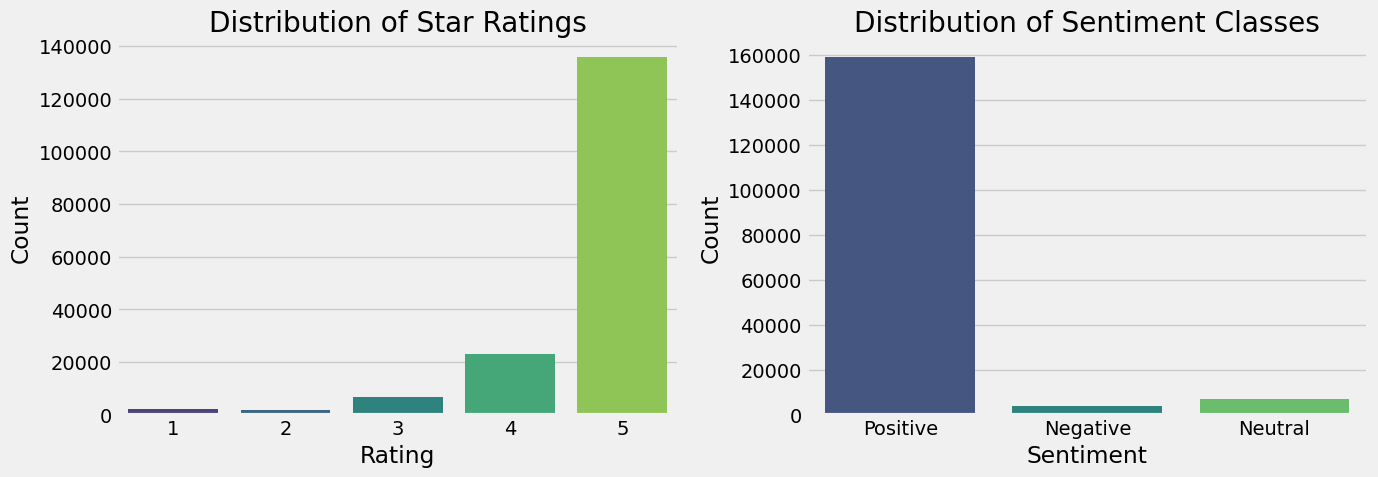


Sample reviews by sentiment:

Negative review (rated 1 stars):
purchased for someone else.

Neutral review (rated 3 stars):
...Which is my only complaint with this record. I pre-ordered the whole thing over a month ago and got the free download. After a month of digesting, I must say that this really is not as musically redeeming as other NIN albums, and thats not because of the lack of vocals. I've always loved NIN since the Broken days and I think every album up to this one was great in its own way. To me, each track on Ghosts seems like an incomplete musical idea. As soon as one track starts to build and get interesting, it ends. Other tracks are just looped sound effects with no real variation. More than anything, this album is a fantastic showcase of electronic sound effects. I think its really cool the types of sounds Trent has made with his electronical synths and moogs, and other various toys. Ghosts really shows you what you are capable of doing with todays modern electronic 

In [ ]:
# Plot the distribution of ratings and sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ratings distribution
sns.countplot(x='overall', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Star Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Sentiment distribution
sns.countplot(x='sentiment_label', data=df, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Sentiment Classes')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Sample reviews by sentiment
print("\nSample reviews by sentiment:")
for sentiment in ['Negative', 'Neutral', 'Positive']:
    sample = df[df['sentiment_label'] == sentiment].sample(1).iloc[0]
    print(f"\n{sentiment} review (rated {sample['overall']} stars):")
    print(sample['reviewText'])


Performing undersampling to balance sentiment classes...
Minority class size (target size for each class): 4004

Undersampling complete.
New Balanced Sentiment Distribution:


,count
sentiment_label,
Negative,4004
Neutral,4004
Positive,4004


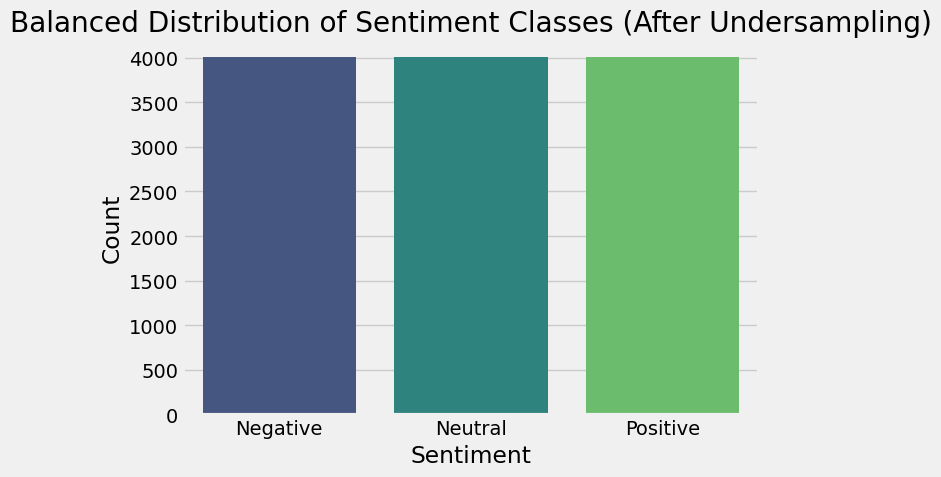

In [ ]:
print("\nPerforming undersampling to balance sentiment classes...")

# Calculate value counts for each sentiment class
sentiment_counts = df['sentiment_label'].value_counts()

# Determine the size of the minority class
minority_class_size = sentiment_counts.min()
print(f"Minority class size (target size for each class): {minority_class_size}")

# Create a list to store the balanced dataframes
balanced_dfs = []

# Sample each class to the size of the minority class
for sentiment_label in sentiment_counts.index:
    # Get the subset of the dataframe for the current sentiment
    sentiment_subset = df[df['sentiment_label'] == sentiment_label]

    # Sample this subset down to the minority class size
    # Use random_state for reproducibility
    sampled_subset = sentiment_subset.sample(n=minority_class_size, random_state=42)

    balanced_dfs.append(sampled_subset)

# Concatenate the sampled dataframes into a single balanced dataframe
df_balanced = pd.concat(balanced_dfs)

# Shuffle the balanced dataframe (optional, but good practice)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nUndersampling complete.")
print("New Balanced Sentiment Distribution:")
display(df_balanced['sentiment_label'].value_counts())

# Visualize the balanced distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment_label', data=df_balanced, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Balanced Distribution of Sentiment Classes (After Undersampling)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
df = df_balanced

In [ ]:
# Text Preprocessing (Test for review text and summary)

def preprocess_text(text, remove_stopwords=True):
    """
    Preprocess the review text:
    - Convert to lowercase
    - Remove special characters and numbers
    - Remove extra whitespaces
    - Optionally remove stopwords (preserving sentiment-carrying words)

    Parameters:
    ----------
    text : str
        Text to preprocess
    remove_stopwords : bool
        Whether to remove stopwords

    Returns:
    -------
    str
        Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords (optional) but preserve sentiment-carrying words
    if remove_stopwords:
        # List of sentiment-carrying stopwords to preserve
        sentiment_stopwords = {
            'no', 'not', 'none', 'nobody', 'nothing', 'nowhere', 'never',
            'dont', 'wont', 'cant', 'couldnt', 'shouldnt', 'wouldnt', 'mustnt',
            'doesnt', 'didnt', 'hadnt', 'hasnt', 'isnt', 'arent', 'wasnt', 'werent',
            'havent', 'aint', 'hardly', 'barely', 'rarely', 'seldom', 'neither',
            'without', 'too', 'very', 'extremely', 'absolutely', 'completely'
        }

        # Get standard stopwords but remove sentiment-carrying ones
        stop_words = set(stopwords.words('english')) - sentiment_stopwords

        # Tokenize and remove stopwords
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words]
        text = ' '.join(tokens)

    return text

# Apply preprocessing to review text
print("Preprocessing reviewText...")
df['processed_text'] = df['reviewText'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
df['processed_text_no_stopwords'] = df['reviewText'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

# Display a sample review before and after preprocessing
sample_idx = np.random.randint(0, len(df))
print("\nSample review before preprocessing:")
print(df.iloc[sample_idx]['reviewText'])
print("\nAfter preprocessing (with stopwords):")
print(df.iloc[sample_idx]['processed_text'])
print("\nAfter preprocessing (without stopwords):")
print(df.iloc[sample_idx]['processed_text_no_stopwords'])

Preprocessing reviewText...

Sample review before preprocessing:
It was good then the radio wouldn't stop playing it. Now I regret buying it. Song makes no sense. And listening to it hurts your head.

After preprocessing (with stopwords):
it was good then the radio wouldnt stop playing it now i regret buying it song makes no sense and listening to it hurts your head

After preprocessing (without stopwords):
good radio wouldnt stop playing regret buying song makes sense listening hurts head


In [ ]:
# These functions should be added to your main code file

def encode_and_plot_eda(model_name, texts, labels, x_max=600):
    """
    Tokenize texts using a pre-trained tokenizer and visualize token length distribution.

    Args:
        model_name (str): Name of the pre-trained model/tokenizer
        texts (list): List of text samples
        labels (list): List of corresponding labels
        x_max (int): Maximum x-axis value for token distribution plot
    """
    from transformers import AutoTokenizer
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize all texts
    token_counts = []
    for text in texts:
        tokens = tokenizer.encode(text, add_special_tokens=True, truncation=False)
        token_counts.append(len(tokens))

    # Create a DataFrame for visualization
    token_df = pd.DataFrame({
        'token_count': token_counts,
        'label': labels
    })

    # Plot overall distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(token_df['token_count'], kde=True)
    plt.axvline(x=512, color='red', linestyle='--', label='BERT limit (512)')
    plt.title('Token Count Distribution')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.xlim(0, x_max)
    plt.legend()

    # Plot distribution by label
    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='token_count', data=token_df)
    plt.title('Token Count by Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Tokens')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Token count statistics:")
    print(f"Mean: {np.mean(token_counts):.1f}")
    print(f"Median: {np.median(token_counts):.1f}")
    print(f"Min: {np.min(token_counts)}")
    print(f"Max: {np.max(token_counts)}")
    print(f"95th percentile: {np.percentile(token_counts, 95):.1f}")
    print(f"99th percentile: {np.percentile(token_counts, 99):.1f}")

    over_limit = sum(1 for x in token_counts if x > 512)
    print(f"Samples over 512 tokens: {over_limit} ({over_limit/len(token_counts)*100:.1f}%)")

    return token_counts

def split_for_finetuning(df, test_size=0.2, random_state=42):
    """
    Split a DataFrame into training and testing sets with stratification.

    Args:
        df (pandas.DataFrame): DataFrame to split
        test_size (float): Proportion of the data to use for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (train_df, test_df)
    """
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np

    print("\nSplitting data into train and test sets...")

    # Stratified split based on sentiment
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df['sentiment']
    )

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # Print statistics
    print(f"Training set: {len(train_df)} samples")
    print(f"Testing set: {len(test_df)} samples")

    # Print class distribution
    print("\nClass distribution:")

    train_dist = train_df['sentiment'].value_counts(normalize=True).sort_index() * 100
    test_dist = test_df['sentiment'].value_counts(normalize=True).sort_index() * 100

    for label in sorted(df['sentiment'].unique()):
        if 'sentiment_label' in df.columns:
            label_name = df[df['sentiment'] == label]['sentiment_label'].iloc[0]
            print(f"Class {label} ({label_name}):")
        else:
            print(f"Class {label}:")

        print(f"  - Train: {train_dist[label]:.2f}%")
        print(f"  - Test:  {test_dist[label]:.2f}%")

    return train_df, test_df

In [ ]:
def prepare_data_pipeline(df, model_name="roberta-base", max_tokens=512, test_size=0.2, random_state=42):
    """
    Complete pipeline to prepare data for fine-tuning:
    1. Tokenize and add token counts with visualization
    2. Filter by token length with detailed metrics
    3. Split into train/test sets with stratification and detailed metrics

    Args:
        df (pandas.DataFrame): DataFrame with 'reviewText' and 'sentiment' columns
        model_name (str): HuggingFace model identifier
        max_tokens (int): Maximum token count to allow
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (train_df, test_df) - DataFrames for training and testing
    """
    print("\n" + "="*80)
    print(f"DATA PREPARATION PIPELINE FOR MODEL: {model_name}")
    print("="*80 + "\n")

    # Step 1: Tokenize and add token counts
    print("\n" + "-"*40)
    print("STEP 1: TOKENIZATION AND VISUALIZATION")
    print("-"*40)

    print(f"Loading tokenizer for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Use the encode_and_plot_eda function to visualize and tokenize
    print("\nRunning tokenization analysis and visualization...")
    encode_and_plot_eda(
        model_name=model_name,
        texts=df['reviewText'].tolist(),
        labels=df['sentiment_label'].tolist(),
        x_max=max_tokens + 100  # Show a bit more than our limit
    )

    # Now add token counts to the dataframe
    print("\nAdding token counts to dataframe...")
    token_counts = []
    for text in df['reviewText']:
        tokens = tokenizer.encode(text, add_special_tokens=True, truncation=False)
        token_counts.append(len(tokens))

    df_with_counts = df.copy()
    df_with_counts['token_count'] = token_counts

    # Step 2: Filter by token length
    print("\n" + "-"*40)
    print("STEP 2: FILTERING BY TOKEN LENGTH")
    print("-"*40)

    print(f"\nTokenizing {len(df)} texts and filtering to max {max_tokens} tokens...")

    # Calculate statistics before filtering
    over_limit_mask = df_with_counts['token_count'] > max_tokens
    over_limit_count = over_limit_mask.sum()
    over_limit_percent = (over_limit_count / len(df_with_counts)) * 100

    # Get some examples of texts that exceed the limit (if any)
    if over_limit_count > 0:
        over_limit_examples = df_with_counts[over_limit_mask].sample(min(3, over_limit_count))
        print("\nExamples of texts exceeding token limit:")
        for i, (idx, row) in enumerate(over_limit_examples.iterrows()):
            print(f"Example {i+1}: {row['token_count']} tokens, text preview: '{row['reviewText'][:50]}...'")

    # Apply the filter
    filtered_df = df_with_counts[df_with_counts['token_count'] <= max_tokens]

    # Report results (similar to filter_by_token_length)
    print(f"\nOriginal dataset size: {len(df_with_counts)} rows")
    print(f"Rows over token limit: {over_limit_count} ({over_limit_percent:.2f}%)")
    print(f"Filtered dataset size: {len(filtered_df)} rows")
    print(f"Removed {len(df_with_counts) - len(filtered_df)} rows")

    # Step 3: Split into train/test sets
    print("\n" + "-"*40)
    print("STEP 3: TRAIN/TEST SPLITTING")
    print("-"*40)

    # Call the existing split_for_finetuning function to preserve its metrics
    train_df, test_df = split_for_finetuning(filtered_df, test_size=test_size, random_state=random_state)

    print("\n" + "="*80)
    print("DATA PREPARATION PIPELINE COMPLETE")
    print("="*80 + "\n")

    return train_df, test_df


DATA PREPARATION PIPELINE FOR MODEL: roberta-base


----------------------------------------
STEP 1: TOKENIZATION AND VISUALIZATION
----------------------------------------
Loading tokenizer for roberta-base...

Running tokenization analysis and visualization...
Running Tokenization EDA for model: roberta-base


Token indices sequence length is longer than the specified maximum sequence length for this model (1039 > 512). Running this sequence through the model will result in indexing errors


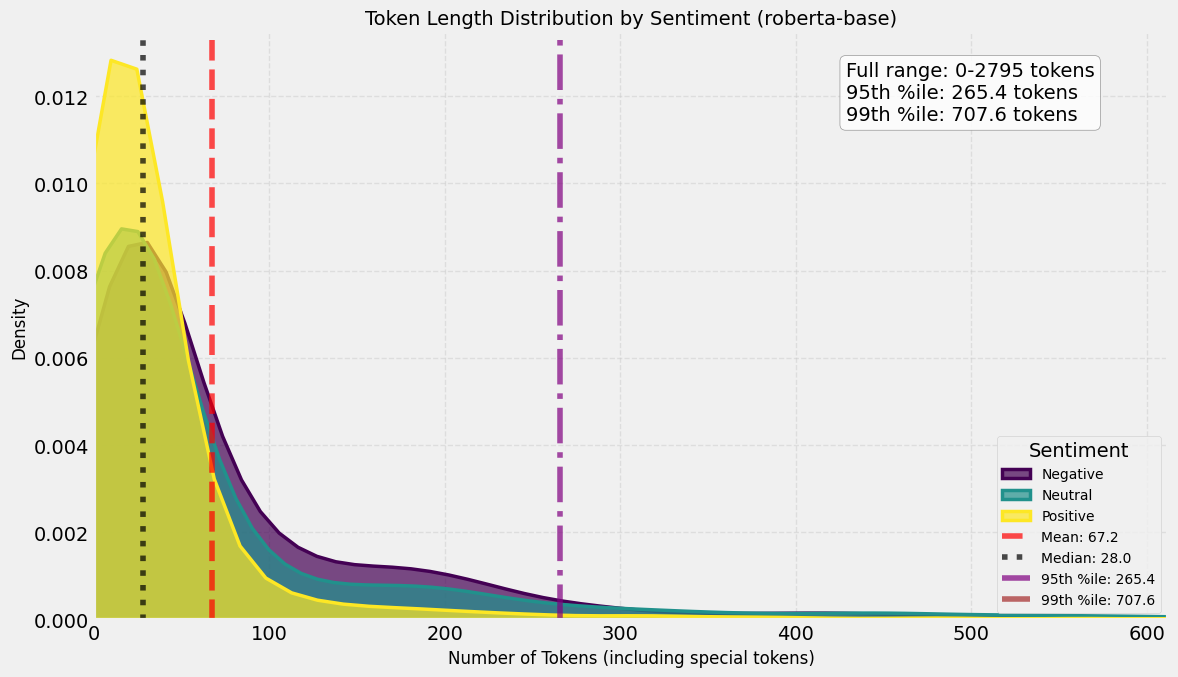

Token indices sequence length is longer than the specified maximum sequence length for this model (1039 > 512). Running this sequence through the model will result in indexing errors


EDA complete for roberta-base tokenizer.
Max token length observed: 2795
Average token length: 67.19
Median token length: 28.0
95th percentile: 265.45
99th percentile: 707.56

Adding token counts to dataframe...

----------------------------------------
STEP 2: FILTERING BY TOKEN LENGTH
----------------------------------------

Tokenizing 12012 texts and filtering to max 512 tokens...

Examples of texts exceeding token limit:
Example 1: 722 tokens, text preview: 'Even when Brandon Flowers makes mistakes on "Flami...'
Example 2: 537 tokens, text preview: '. . . but I will admit that my doubts (after heari...'
Example 3: 544 tokens, text preview: 'I have had this one for thirteen years, enjoying a...'

Original dataset size: 12012 rows
Rows over token limit: 218 (1.81%)
Filtered dataset size: 11794 rows
Removed 218 rows

----------------------------------------
STEP 3: TRAIN/TEST SPLITTING
----------------------------------------
Splitting data into train (80%) and test (20%) sets...

Da

In [ ]:
# Prepare data with token counts, filtering, and splitting
train_df, test_df = prepare_data_pipeline(
    df,
    model_name="roberta-base",
    max_tokens=512,
    test_size=0.2
)

In [ ]:
def finetune_and_evaluate_sentiment_model_lora(
    train_df,
    test_df,
    model_name="cardiffnlp/twitter-roberta-base-sentiment",
    batch_size=16,
    learning_rate=2e-5,
    lora_alpha=16,
    lora_dropout=0.1,
    lora_r=8,
    lora_bias="none",
    modules_to_save=None,
    attn_learning_rate_multiplier=0.5,  # The second learning rate for Two-Rate LoRA
    epochs=3,
    max_length=512
):
    """
    Fine-tune a transformer model for sentiment analysis using LoRA⁺ (Two-Rate LoRA)
    from the PEFT library and evaluate its performance.

    Args:
        train_df (pandas.DataFrame): Training data with 'reviewText' and 'sentiment' columns
        test_df (pandas.DataFrame): Testing data with 'reviewText' and 'sentiment' columns
        model_name (str): HuggingFace model identifier
        batch_size (int): Batch size for training
        learning_rate (float): Base learning rate for optimization
        lora_alpha (int): LoRA alpha parameter (scaling factor)
        lora_dropout (float): Dropout probability for LoRA layers
        lora_r (int): LoRA rank parameter
        lora_bias (str): LoRA bias configuration
        modules_to_save (list): List of modules to save fully (not using LoRA)
        attn_learning_rate_multiplier (float): Multiplier for attention learning rate in Two-Rate LoRA
        epochs (int): Number of training epochs
        max_length (int): Maximum sequence length for tokenization

    Returns:
        dict: Dictionary containing evaluation metrics and the trained model
    """
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification
    )
    from datasets import Dataset
    import os
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
    import gc
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from tqdm.auto import tqdm

    # Import PEFT library components for LoRA
    from peft import (
        LoraConfig,
        TaskType,
        get_peft_model,
        prepare_model_for_kbit_training,
        PeftModel
    )

    # Check transformers and PEFT versions
    import transformers
    import peft
    print(f"Transformers version: {transformers.__version__}")
    print(f"PEFT version: {peft.__version__}")

    # Disable wandb completely
    os.environ["WANDB_DISABLED"] = "true"

    # Check GPU availability and configure settings
    print("Checking GPU availability...")
    if torch.cuda.is_available():
        print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        device = torch.device("cuda")
    else:
        print("❌ GPU not available, using CPU instead")
        device = torch.device("cpu")

    # Function for memory management
    def clear_gpu_memory():
        """Clear GPU memory cache to prevent out-of-memory errors"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
            print("GPU memory cleared")

    # Set fixed seeds for reproducibility
    import random
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Check if token_count column exists
    if 'token_count' in train_df.columns and 'token_count' in test_df.columns:
        if train_df['token_count'].max() > max_length or test_df['token_count'].max() > max_length:
            print(f"Warning: Some texts exceed the max_length of {max_length}. They will be truncated during tokenization.")

    # Convert DataFrames to HuggingFace datasets for tokenization
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Load tokenizer and model
    print(f"Loading tokenizer and model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Get number of labels from the data
    num_labels = len(train_df['sentiment'].unique())
    print(f"Detected {num_labels} sentiment classes")

    # Load pre-trained model with classification head
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    # Define the target modules to apply LoRA to
    # For RoBERTa, we typically target the attention layers
    target_modules = ["query", "key", "value"]

    # Configure Two-Rate LoRA
    # Using different learning rates for attention modules (controlled by attn_learning_rate_multiplier)
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,  # Sequence Classification
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias=lora_bias,
        target_modules=target_modules,
        modules_to_save=modules_to_save,
        inference_mode=False
    )

    # Prepare model for LoRA fine-tuning
    print("Applying LoRA to model...")
    model = get_peft_model(model, peft_config)

    # Print trainable parameters info
    model.print_trainable_parameters()

    # Move model to device
    model.to(device)

    # Tokenize function for datasets
    def tokenize_function(examples):
        return tokenizer(
            examples['reviewText'],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors=None  # Will convert to tensors later
        )

    # Tokenize datasets
    print("Preparing datasets for training...")
    train_tokenized = train_dataset.map(tokenize_function, batched=True)
    test_tokenized = test_dataset.map(tokenize_function, batched=True)

    # Convert to PyTorch tensors and create datasets
    print("Creating PyTorch datasets...")
    train_input_ids = torch.tensor(train_tokenized['input_ids'], dtype=torch.long)
    train_attention_mask = torch.tensor(train_tokenized['attention_mask'], dtype=torch.long)
    train_labels = torch.tensor(train_df['sentiment'].values, dtype=torch.long)

    test_input_ids = torch.tensor(test_tokenized['input_ids'], dtype=torch.long)
    test_attention_mask = torch.tensor(test_tokenized['attention_mask'], dtype=torch.long)
    test_labels = torch.tensor(test_df['sentiment'].values, dtype=torch.long)

    # Create tensor datasets
    train_tensor_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
    test_tensor_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

    # Create dataloaders WITHOUT shuffle - we'll do our own shuffling
    train_dataloader = DataLoader(
        train_tensor_dataset,
        batch_size=batch_size,
        shuffle=False,  # No shuffle, we'll do it manually
        pin_memory=False  # Avoid pin_memory issues
    )

    test_dataloader = DataLoader(
        test_tensor_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=False
    )

    # Set up the optimizer with Two-Rate LoRA - different learning rates for different parameter groups
    # Create parameter groups for different learning rates
    optimizer_grouped_parameters = []

    # Group 1: LoRA attention parameters (with multiplier for Two-Rate approach)
    query_key_value_params = []
    other_lora_params = []

    # Separate attention and non-attention LoRA parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            if any(attn_name in name for attn_name in ["query", "key", "value"]):
                query_key_value_params.append(param)
            else:
                other_lora_params.append(param)

    # Two-Rate LoRA: different learning rates
    optimizer_grouped_parameters.append(
        {"params": query_key_value_params, "lr": learning_rate * attn_learning_rate_multiplier}
    )
    optimizer_grouped_parameters.append(
        {"params": other_lora_params, "lr": learning_rate}
    )

    # Create the optimizer
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, weight_decay=0.01)

    # Calculate number of training steps
    total_steps = len(train_dataloader) * epochs

    # Setup learning rate scheduler with warmup
    from transformers import get_scheduler
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # Training loop
    print("Starting model fine-tuning with LoRA⁺...")
    try:
        model.train()
        epoch_losses = []

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")

            # Manually shuffle the training indices
            indices = list(range(len(train_tensor_dataset)))
            random.shuffle(indices)

            # Create shuffled batches
            batches = [indices[i:i + batch_size] for i in range(0, len(indices), batch_size)]

            progress_bar = tqdm(batches)
            epoch_loss = 0

            for batch_indices in progress_bar:
                # Get data for these indices
                batch_input_ids = train_input_ids[batch_indices].to(device)
                batch_attention_mask = train_attention_mask[batch_indices].to(device)
                batch_labels = train_labels[batch_indices].to(device)

                # Forward pass
                outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask,
                    labels=batch_labels
                )

                loss = outputs.loss
                epoch_loss += loss.item()

                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                # Update progress bar
                progress_bar.set_description(f"Loss: {loss.item():.4f}")

            # Calculate average loss for the epoch
            avg_epoch_loss = epoch_loss / len(batches)
            epoch_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1} average loss: {avg_epoch_loss:.4f}")

            # Evaluation at the end of each epoch
            model.eval()
            eval_accuracy = 0
            with torch.no_grad():
                for batch in tqdm(test_dataloader, desc="Evaluating"):
                    batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

                    outputs = model(
                        input_ids=batch_input_ids,
                        attention_mask=batch_attention_mask
                    )

                    predictions = torch.argmax(outputs.logits, dim=-1)
                    eval_accuracy += (predictions == batch_labels).sum().item()

            eval_accuracy /= len(test_tensor_dataset)
            print(f"Epoch {epoch+1} evaluation accuracy: {eval_accuracy:.4f}")

            # Set back to training mode for next epoch
            model.train()

        # Final evaluation
        print("\nFinal evaluation...")
        model.eval()
        all_predictions = []
        all_true_labels = []

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Final evaluation"):
                batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )

                predictions = torch.argmax(outputs.logits, dim=-1)

                all_predictions.extend(predictions.cpu().numpy())
                all_true_labels.extend(batch_labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_true_labels, all_predictions)
        print(f"Final accuracy: {accuracy:.4f}")

        # Calculate confusion matrix
        cm = confusion_matrix(all_true_labels, all_predictions)

        # Get classification report
        class_names = [f'Class {i}' for i in range(num_labels)]
        if 'sentiment_label' in train_df.columns:
            # Use actual class names if available
            unique_labels = sorted(train_df['sentiment_label'].unique())
            if len(unique_labels) == num_labels:
                class_names = unique_labels

        report = classification_report(
            all_true_labels,
            all_predictions,
            output_dict=True,
            target_names=class_names
        )

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        # Plot classification report as a heatmap
        report_df = pd.DataFrame(report).T
        report_df = report_df.drop('accuracy', errors='ignore')

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            report_df.iloc[:-1, :3].astype(float),
            annot=True,
            cmap='Greens'
        )
        plt.title('Classification Report Heatmap')
        plt.show()

        # Print text classification report
        print("\nClassification Report:")
        print(classification_report(
            all_true_labels,
            all_predictions,
            target_names=class_names
        ))

        # Save the LoRA adapter
        print("\nSaving LoRA adapter...")
        model.save_pretrained("lora_plus_adapter")

        # Run garbage collection to free up memory
        clear_gpu_memory()

        # Return results and model
        return {
            "accuracy": accuracy,
            "confusion_matrix": cm,
            "classification_report": report,
            "model": model,
            "tokenizer": tokenizer,
            "predictions": all_predictions,
            "true_labels": all_true_labels,
            "losses": epoch_losses,
            "lora_config": peft_config
        }

    except Exception as e:
        # If any error occurs during training, clean up and report the error
        clear_gpu_memory()
        print(f"Error during training: {e}")
        raise e

Transformers version: 4.51.3
Checking GPU availability...
✅ GPU is available: Tesla T4
Total GPU Memory: 15.83 GB
Loading tokenizer and model: cardiffnlp/twitter-roberta-base-sentiment
Detected 3 sentiment classes
Preparing datasets for training...


Map:   0%|          | 0/9435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2359 [00:00<?, ? examples/s]

Creating PyTorch datasets...
Starting model fine-tuning...
Epoch 1/3


  0%|          | 0/1180 [00:00<?, ?it/s]

Epoch 1 average loss: 0.6630


Evaluating:   0%|          | 0/295 [00:00<?, ?it/s]

Epoch 1 evaluation accuracy: 0.7554
Epoch 2/3


  0%|          | 0/1180 [00:00<?, ?it/s]

Epoch 2 average loss: 0.4745


Evaluating:   0%|          | 0/295 [00:00<?, ?it/s]

Epoch 2 evaluation accuracy: 0.7762
Epoch 3/3


  0%|          | 0/1180 [00:00<?, ?it/s]

Epoch 3 average loss: 0.3146


Evaluating:   0%|          | 0/295 [00:00<?, ?it/s]

Epoch 3 evaluation accuracy: 0.7838

Final evaluation...


Final evaluation:   0%|          | 0/295 [00:00<?, ?it/s]

Final accuracy: 0.7838


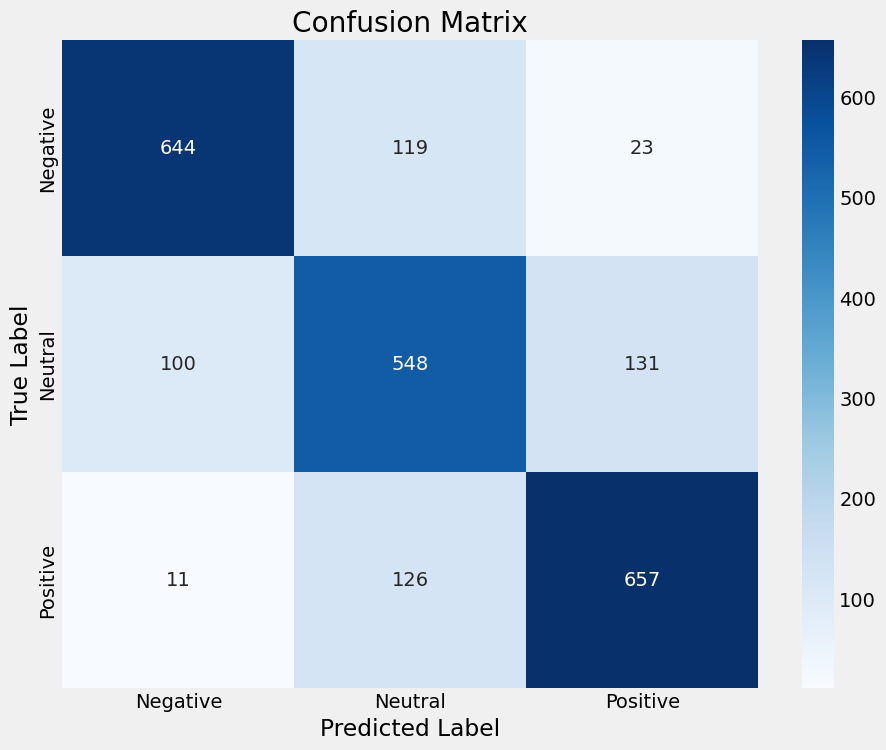

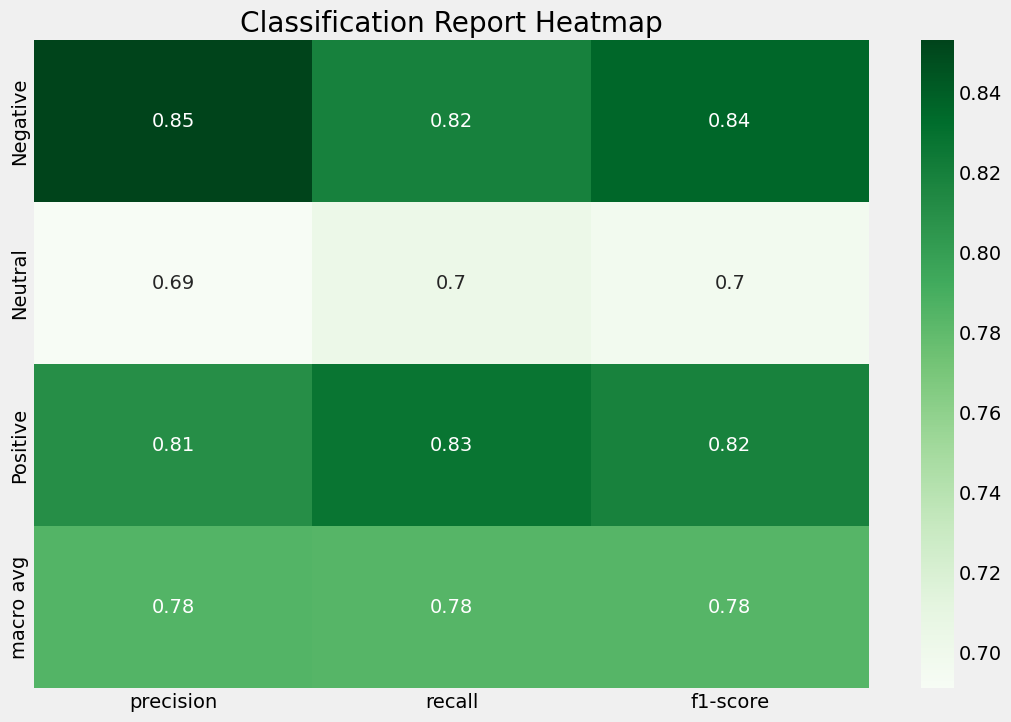


Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.84       786
     Neutral       0.69      0.70      0.70       779
    Positive       0.81      0.83      0.82       794

    accuracy                           0.78      2359
   macro avg       0.78      0.78      0.78      2359
weighted avg       0.79      0.78      0.78      2359

GPU memory cleared
Final model accuracy: 0.7838


In [ ]:
# Fine-tune the model with LoRA⁺ (Two-Rate LoRA)
results = finetune_and_evaluate_sentiment_model_lora(
    train_df,
    test_df,
    model_name="cardiffnlp/twitter-roberta-base-sentiment",
    batch_size=8,  # Lower batch size for better memory management
    learning_rate=2e-5,
    lora_r=8,  # LoRA rank
    lora_alpha=16,  # LoRA alpha (scaling)
    lora_dropout=0.1,  # LoRA dropout
    attn_learning_rate_multiplier=0.5,  # Second learning rate for Two-Rate LoRA
    epochs=3,
    max_length=512
)

# Examine the results
print(f"Final model accuracy: {results['accuracy']:.4f}")
print(f"LoRA trainable parameters: {results['model'].num_parameters(only_trainable=True)}")
print(f"Total parameters: {results['model'].num_parameters()}")

In [ ]:
# Analyze disagreements between rating-based and predicted sentiment
test_df['predicted_sentiment'] = results['predictions']

# Map numeric predictions to sentiment labels
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
test_df['predicted_sentiment_label'] = test_df['predicted_sentiment'].map(sentiment_map)

# Analyze disagreements between rating-based and predicted sentiment
disagreements = test_df[test_df['sentiment'] != test_df['predicted_sentiment']]
print(f"\nNumber of disagreements: {len(disagreements)} ({len(disagreements)/len(test_df)*100:.2f}%)")

# Display a few examples of disagreements
if len(disagreements) > 0:
    print("\nExamples of disagreements:")
    for i, row in disagreements.head(3).iterrows():
        print(f"\nReview: {row['reviewText'][:150]}...")  # Show first 150 chars of review
        print(f"Rating: {row['overall'] if 'overall' in row else 'N/A'} stars (interpreted as {row['sentiment_label']})")
        print(f"Model prediction: {row['predicted_sentiment_label']}")


Number of disagreements: 510 (21.62%)

Examples of disagreements:

Review: Why does this sound like "Welcome to: Eminem's House"??!?!  This may be one of the most disappointing albums of the year, I do not even know what happ...
Rating: 3 stars (interpreted as Neutral)
Model prediction: Negative

Review: just as I had ordered...
Rating: 2 stars (interpreted as Negative)
Model prediction: Neutral

Review: Quality album from MJB. Like all of her work the CD is filled with raw emotional songs. Mixed in with upbeat tracks that make you wanna jam....
Rating: 3 stars (interpreted as Neutral)
Model prediction: Positive


2025-05-06 18:20:29,942 - BERTopic - Embedding - Transforming documents to embeddings.


Extracting topics from reviews...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2025-05-06 18:20:37,409 - BERTopic - Embedding - Completed ✓
2025-05-06 18:20:37,410 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-06 18:20:56,329 - BERTopic - Dimensionality - Completed ✓
2025-05-06 18:20:56,333 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-06 18:20:56,506 - BERTopic - Cluster - Completed ✓
2025-05-06 18:20:56,508 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-06 18:20:56,674 - BERTopic - Representation - Completed ✓
2025-05-06 18:20:56,677 - BERTopic - Topic reduction - Reducing number of topics
2025-05-06 18:20:56,700 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-06 18:20:56,853 - BERTopic - Representation - Completed ✓
2025-05-06 18:20:56,857 - BERTopic - Topic reduction - Reduced number of topics from 47 to 8



Top topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,767,-1_like_just_love_really,"[like, just, love, really, good, great, dont, ...",[this is an awesome song i just had to buy it ...
1,0,1050,0_like_really_just_good,"[like, really, just, good, great, love, dont, ...",[i remember when flame was no pun intended hot...
2,1,173,1_price_got_dont_easy,"[price, got, dont, easy, just, item, fine, lik...",[this is one of those songs that just gets stu...
3,2,122,2_good_great_item_bad,"[good, great, item, bad, mistake, fast, thanks...","[no good, good, good annum]"
4,3,97,3_ok_mistake_just_fine,"[ok, mistake, just, fine, price, said, good, l...","[ok, ok, ok]"
5,4,60,4_item_great_didnt_price,"[item, great, didnt, price, said, got, liked, ...","[i dont think i purchased this item sorry, pro..."
6,5,51,5_love_thanks_liked_good,"[love, thanks, liked, good, great, , , , , ]","[love, love, love it]"
7,6,39,6_like_dont_way_didnt,"[like, dont, way, didnt, got, love, ok, really...","[like it play now, like it, i like it]"



Top words for each topic:
Topic -1: Outlier topic
Topic 0: like, really, just, good, great, love, dont, bad
Topic 1: price, got, dont, easy, just, item, fine, like
Topic 2: good, great, item, bad, mistake, fast, thanks, fine
Topic 3: ok, mistake, just, fine, price, said, good, like
Topic 4: item, great, didnt, price, said, got, liked, dont
Topic 5: love, thanks, liked, good, great, , , 
Topic 6: like, dont, way, didnt, got, love, ok, really


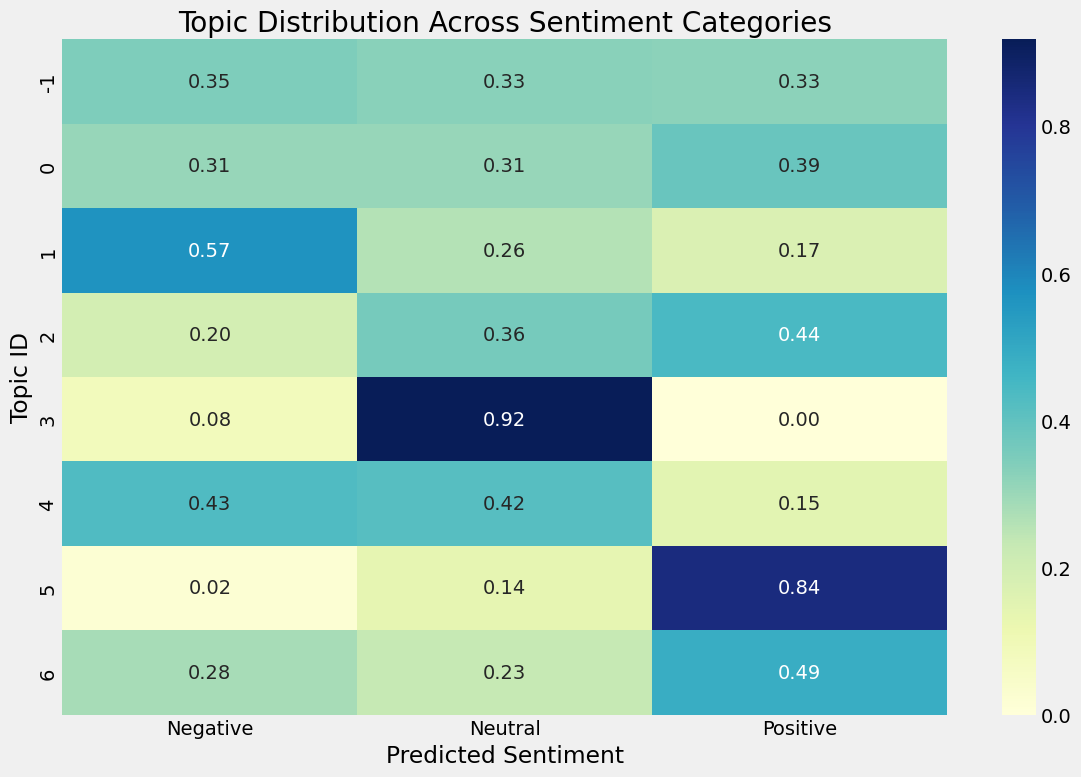

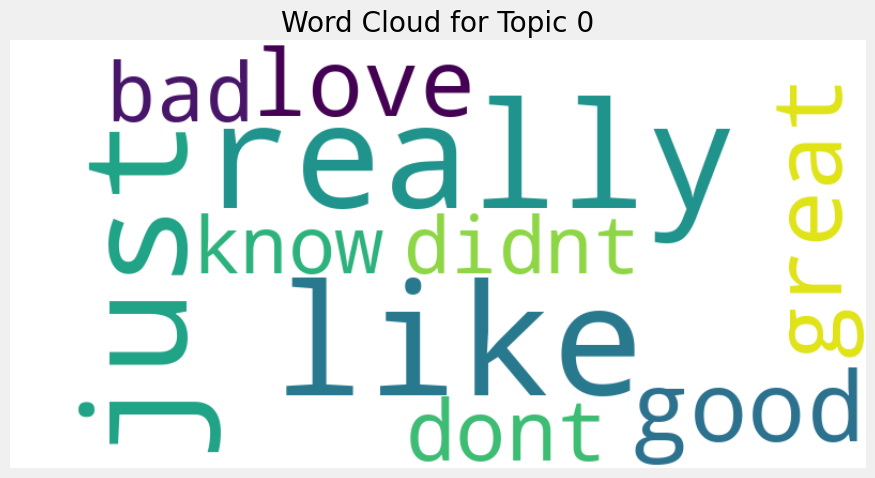

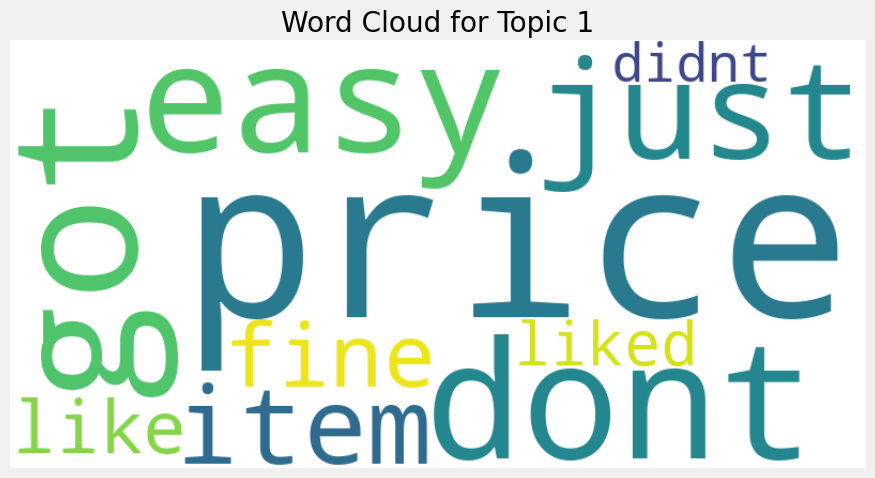

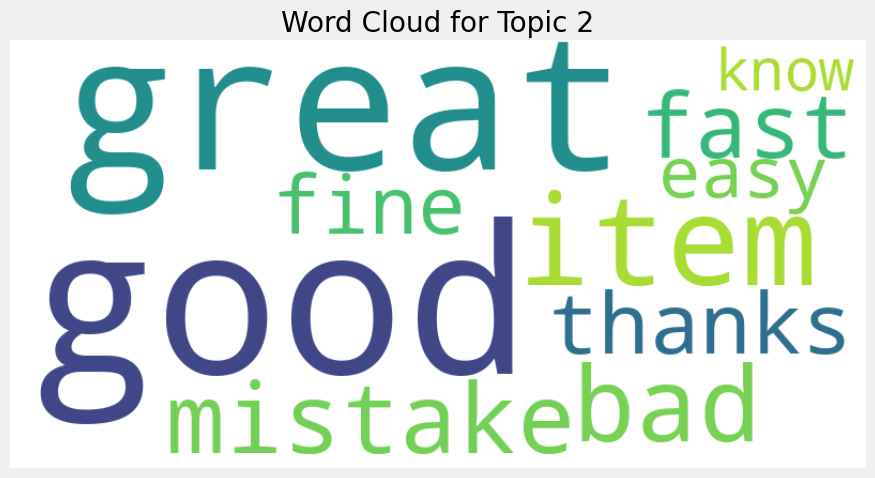


Topic 0 sentiment distribution:
predicted_sentiment_label
Positive    406
Neutral     322
Negative    322
Name: count, dtype: int64

Example reviews for Topic 0:

Negative review example:
Not really a good song...

Neutral review example:
Good music...

Positive review example:
Good song....

Topic 1 sentiment distribution:
predicted_sentiment_label
Negative    98
Neutral     45
Positive    30
Name: count, dtype: int64

Example reviews for Topic 1:

Negative review example:
the music sucks only got it because it was free...

Neutral review example:
Since I have purchased the Kindle Fire and now I have purchased the Kindle Fire HD, I am transferring all of my music and I will be enjoying the music...

Positive review example:
One of the better disco songs.  I thought I had it in my collection and was surprised to discover that I didn't.  Ordered the MP3 version to fill the ...

Topic 2 sentiment distribution:
predicted_sentiment_label
Positive    54
Neutral     44
Negative    24
Name: 

In [ ]:
# Topic Modeling with BERTopic
def extract_topics(texts, n_topics=10, min_docs=5, max_df=0.95):
    """
    Extract topics from review texts using BERTopic.

    Parameters:
    ----------
    texts : list
        List of preprocessed texts
    n_topics : int
        Number of topics to extract
    min_docs : int
        Minimum document frequency for CountVectorizer
    max_df : float
        Maximum document frequency for CountVectorizer

    Returns:
    -------
    BERTopic model
        Trained topic model
    list
        Topic assignments for each text
    """
    # Set up the vectorizer with proper parameters
    vectorizer = CountVectorizer(stop_words="english", min_df=min_docs, max_df=max_df)

    # Initialize and train BERTopic model
    topic_model = BERTopic(
        nr_topics=n_topics,
        vectorizer_model=vectorizer,
        verbose=True
    )

    # Fit the model and transform documents to get topic assignments
    topics, probs = topic_model.fit_transform(texts)

    return topic_model, topics, probs

# Extract topics from the preprocessed reviews
print("Extracting topics from reviews...")
topic_model, topic_assignments, topic_probs = extract_topics(
    test_df['processed_text_no_stopwords'].tolist(),  # Use test_df to match with predictions
    n_topics=8  # Starting with fewer topics is often cleaner
)

# Add topic assignments to the test dataframe
test_df['topic'] = topic_assignments

# Get and display the top topics
top_topics = topic_model.get_topic_info().head(10)
print("\nTop topics:")
display(top_topics)

# Display top words for each topic
print("\nTop words for each topic:")
for topic_id in top_topics['Topic'].tolist():
    if topic_id == -1:
        print(f"Topic {topic_id}: Outlier topic")
        continue

    topic_words = topic_model.get_topic(topic_id)
    words = [word for word, _ in topic_words]
    print(f"Topic {topic_id}: {', '.join(words[:8])}")

# Create a heatmap to show topic distribution across sentiment categories
import matplotlib.pyplot as plt
import seaborn as sns

# Create a cross-tabulation of topics vs sentiment
topic_sentiment = pd.crosstab(
    test_df['topic'],
    test_df['predicted_sentiment_label'],
    normalize='index'  # Normalize by row (topic)
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_sentiment, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Topic Distribution Across Sentiment Categories')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Topic ID')
plt.tight_layout()
plt.show()

# Create word clouds for top topics
from wordcloud import WordCloud

# Function to create word cloud from topic
def create_topic_wordcloud(topic_model, topic_id, title):
    topic_words = topic_model.get_topic(topic_id)
    word_dict = {word: weight for word, weight in topic_words}

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate_from_frequencies(word_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create word clouds for top 3 topics (excluding -1 if it's there)
regular_topics = [t for t in top_topics['Topic'].tolist() if t != -1][:3]
for topic_id in regular_topics:
    create_topic_wordcloud(
        topic_model,
        topic_id,
        f'Word Cloud for Topic {topic_id}'
    )

# Find representative reviews for each topic
for topic_id in regular_topics:
    # Get reviews with this topic
    topic_reviews = test_df[test_df['topic'] == topic_id]

    # Display sentiment distribution for this topic
    print(f"\nTopic {topic_id} sentiment distribution:")
    print(topic_reviews['predicted_sentiment_label'].value_counts())

    # Show a sample review from each sentiment
    print(f"\nExample reviews for Topic {topic_id}:")
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        sentiment_reviews = topic_reviews[topic_reviews['predicted_sentiment_label'] == sentiment]
        if len(sentiment_reviews) > 0:
            sample = sentiment_reviews.sample(1).iloc[0]
            print(f"\n{sentiment} review example:")
            print(sample['reviewText'][:150] + "...")

<Figure size 1400x800 with 0 Axes>

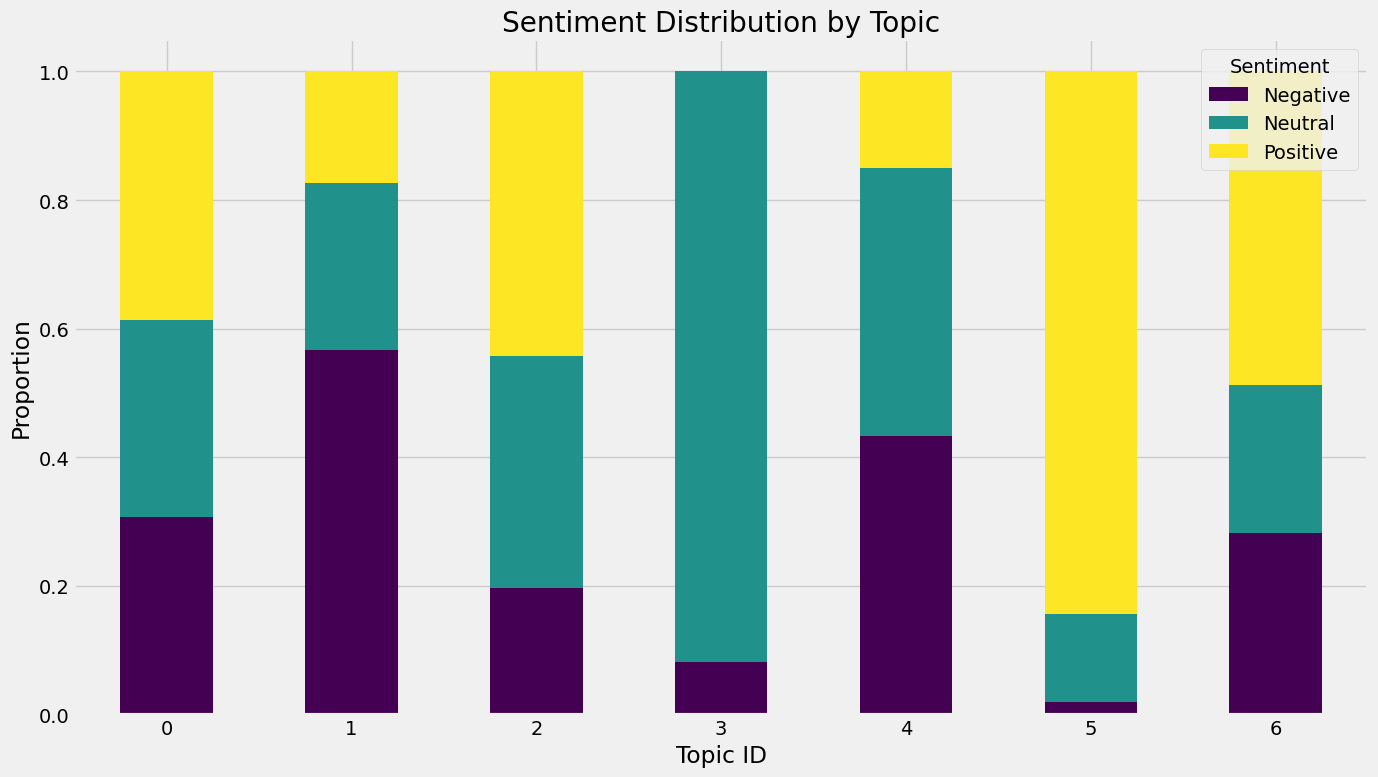

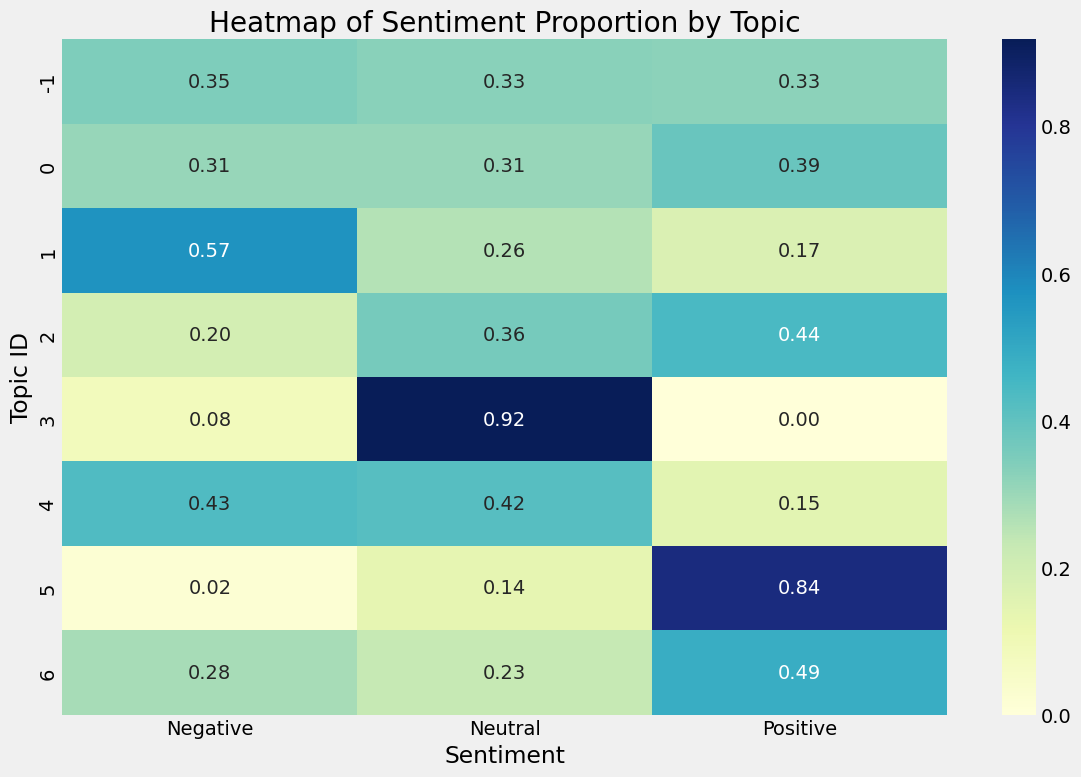


Topics ranked by sentiment (from most negative to most positive):
Topic 1 (price, got, dont, easy, just): 0.61 - Negative
Topic 4 (item, great, didnt, price, said): 0.72 - Negative
Topic 3 (ok, mistake, just, fine, price): 0.92 - Negative
Topic 0 (like, really, just, good, great): 1.08 - Neutral
Topic 6 (like, dont, way, didnt, got): 1.21 - Neutral
Topic 2 (good, great, item, bad, mistake): 1.25 - Neutral
Topic 5 (love, thanks, liked, good, great): 1.82 - Positive

Most representative reviews by topic and sentiment:

--- TOPIC 0 ---
Keywords: like, really, just, good, great

Negative review example:
Review: I really am shocked by all the good reviews.  This really is a 1-2 star album at most.  Definately no Fear.  Unmemorable songs, lite-pop production.  ...

Neutral review example:
Review: It was OK at first, but now it's better. I saw the video and Rihanna was undressed in lingerie or something and I was like, "Wow". I didn't think she'...

Positive review example:
Review: I know th

In [ ]:
# Cross-Analysis: Sentiment by Topic

# Count documents by topic and sentiment
topic_sentiment_counts = test_df.groupby(['topic', 'predicted_sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)

# Filter out the outlier topic (-1)
if -1 in topic_sentiment_props.index:
    topic_sentiment_filtered = topic_sentiment_props.drop(-1)
else:
    topic_sentiment_filtered = topic_sentiment_props

# Plot sentiment distribution by topic
plt.figure(figsize=(14, 8))
topic_sentiment_filtered.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic ID')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Create a heatmap of sentiment by topic
sentiment_topic_pivot = pd.crosstab(
    test_df['topic'],
    test_df['predicted_sentiment_label'],
    normalize='index'
)

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_topic_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Sentiment Proportion by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic ID')
plt.tight_layout()
plt.show()

# Identify the most positive and negative topics
topic_sentiment_mean = test_df.groupby('topic')['predicted_sentiment'].mean().sort_values()
print("\nTopics ranked by sentiment (from most negative to most positive):")
for topic_id, sentiment_score in topic_sentiment_mean.items():
    if topic_id == -1:
        continue
    # Get top words for this topic (with error handling in case topic doesn't exist)
    try:
        topic_words = ', '.join([word for word, _ in topic_model.get_topic(topic_id)][:5])
    except:
        topic_words = "Unknown topic"

    # Determine sentiment label based on score
    if sentiment_score < 0.5:
        sentiment_label = 'Strongly Negative'
    elif sentiment_score < 1.0:
        sentiment_label = 'Negative'
    elif sentiment_score < 1.5:
        sentiment_label = 'Neutral'
    elif sentiment_score < 2.0:
        sentiment_label = 'Positive'
    else:
        sentiment_label = 'Strongly Positive'

    print(f"Topic {topic_id} ({topic_words}): {sentiment_score:.2f} - {sentiment_label}")

# Optional: Add a visualization of the most representative reviews
# Get the most representative reviews for each topic
print("\nMost representative reviews by topic and sentiment:")
for topic_id in topic_sentiment_filtered.index[:3]:  # Limit to top 3 topics for brevity
    print(f"\n--- TOPIC {topic_id} ---")
    topic_keywords = ', '.join([word for word, _ in topic_model.get_topic(topic_id)][:5])
    print(f"Keywords: {topic_keywords}")

    # Get reviews for this topic
    topic_reviews = test_df[test_df['topic'] == topic_id]

    # For each sentiment, show the most representative review
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        sentiment_reviews = topic_reviews[topic_reviews['predicted_sentiment_label'] == sentiment]

        if len(sentiment_reviews) > 0:
            # Sort by probability (if available) or just take a sample
            if 'topic_prob' in sentiment_reviews.columns:
                sample = sentiment_reviews.sort_values('topic_prob', ascending=False).iloc[0]
            else:
                sample = sentiment_reviews.sample(1).iloc[0]

            print(f"\n{sentiment} review example:")
            print(f"Review: {sample['reviewText'][:150]}...")

In [ ]:
# Interactive Visualization with Plotly
print("\nGenerating interactive visualizations...")

# 1. Interactive Sentiment Distribution (Corrected)
print("Creating sentiment distribution bar chart...")
try:
    # Calculate value counts and reset index into a DataFrame
    sentiment_data_for_plot = test_df['predicted_sentiment_label'].value_counts().reset_index()

    # Dynamically get the actual column names
    if len(sentiment_data_for_plot.columns) == 2:
        label_col_name = sentiment_data_for_plot.columns[0]
        count_col_name = sentiment_data_for_plot.columns[1]

        print(f"Plotting sentiment distribution with: x='{label_col_name}', y='{count_col_name}'")

        fig_bar = px.bar(
            sentiment_data_for_plot,
            x=label_col_name,
            y=count_col_name,
            color=label_col_name,
            color_discrete_sequence=px.colors.qualitative.Set1,
            labels={label_col_name: 'Sentiment', count_col_name: 'Number of Reviews'},
            title='Interactive Sentiment Distribution'
        )
        fig_bar.show()
    else:
        print("Warning: Could not automatically determine columns for sentiment distribution plot. Skipping.")

except KeyError:
    print("Warning: 'predicted_sentiment_label' column not found. Skipping sentiment distribution plot.")
except Exception as e:
    print(f"An error occurred during sentiment distribution plot generation: {e}")


# 2. Interactive Topic-Sentiment Heatmap (With Check)
print("\nCreating topic-sentiment heatmap...")
try:
    # Check if required columns exist
    if 'topic' in test_df.columns and 'predicted_sentiment_label' in test_df.columns:
        topic_sent_df = pd.crosstab(
            test_df['topic'],
            test_df['predicted_sentiment_label']
        )

        # Check if the crosstab is empty before plotting
        if not topic_sent_df.empty:
            fig_heatmap = px.imshow(
                topic_sent_df,
                labels=dict(x="Sentiment", y="Topic", color="Count"),
                x=topic_sent_df.columns,
                y=topic_sent_df.index,
                color_continuous_scale='Viridis',
                title='Interactive Topic-Sentiment Heatmap'
            )
            fig_heatmap.show()
        else:
            print("Warning: Topic-Sentiment crosstab is empty (no overlapping data). Skipping heatmap.")
    else:
        print("Warning: 'topic' or 'predicted_sentiment_label' column missing. Skipping topic-sentiment heatmap.")

except Exception as e:
    print(f"An error occurred during topic-sentiment heatmap generation: {e}")


# 3. Sunburst Chart of Topics and Sentiments (With Check)
print("\nCreating sentiment-topic sunburst chart...")
try:
    # Check if required columns exist
    if 'topic' in test_df.columns and 'predicted_sentiment_label' in test_df.columns:
        # Create topic names (handle potential NaN topics if necessary)
        df_filtered_sunburst = test_df.dropna(subset=['topic', 'predicted_sentiment_label'])
        if not df_filtered_sunburst.empty:
            # Get topic keywords to add to the labels
            topic_names = {}
            for topic_id in df_filtered_sunburst['topic'].unique():
                if topic_id == -1:
                    topic_names[topic_id] = "Outlier Topic"
                else:
                    try:
                        # Get top 2 words for this topic
                        top_words = [word for word, _ in topic_model.get_topic(topic_id)][:2]
                        topic_names[topic_id] = f"Topic {int(topic_id)}: {', '.join(top_words)}"
                    except:
                        topic_names[topic_id] = f"Topic {int(topic_id)}"

            df_filtered_sunburst['topic_name'] = df_filtered_sunburst['topic'].map(topic_names)

            fig_sunburst = px.sunburst(
                df_filtered_sunburst,
                path=['predicted_sentiment_label', 'topic_name'],
                title='Sunburst Chart: Sentiment → Topic',
                color_discrete_sequence=px.colors.qualitative.Bold
            )
            fig_sunburst.show()
        else:
             print("Warning: No valid data found for sunburst chart after filtering NaNs. Skipping.")
    else:
        print("Warning: 'topic' or 'predicted_sentiment_label' column missing. Skipping sunburst chart.")

except Exception as e:
    print(f"An error occurred during sunburst chart generation: {e}")

print("\nInteractive visualization generation complete.")


Generating interactive visualizations...
Creating sentiment distribution bar chart...
Plotting sentiment distribution with: x='predicted_sentiment_label', y='count'



Creating topic-sentiment heatmap...



Creating sentiment-topic sunburst chart...



Interactive visualization generation complete.


In [ ]:
# def save_model(df, topic_model, file_name='sentiment_analysis_data.joblib'):
#     """
#     Save the necessary data and models for Streamlit deployment using joblib.
#     Joblib is more efficient than pickle especially for objects that contain
#     large numpy arrays, which is common in ML models.

#     Parameters:
#     ----------
#     df : pd.DataFrame
#         Processed dataframe
#     topic_model : BERTopic
#         Trained topic model
#     file_name : str
#         File name to save the data
#     """
#     import joblib

#     # Create a dictionary with all necessary components
#     project_data = {
#         'sample_data': df,
#         'topic_model': topic_model,
#         'metadata': {
#             'created_at': pd.Timestamp.now(),
#             'sample_size': len(df),
#             'top_topics': topic_model.get_topic_info().head(10).to_dict()
#         }
#     }

#     # Save to file using joblib for better performance with scientific computing objects
#     joblib.dump(project_data, file_name, compress=3)

#     print(f"Data saved to {file_name} for Streamlit deployment using joblib")

# # Save the necessary data for Streamlit deployment
# save_model(df, topic_model)